# EGTA Framework Exploration

This notebook demonstrates how to use the Empirical Game-Theoretic Analysis (EGTA) framework to explore strategic interactions between agents deciding how to allocate their trading between traditional CDA markets and the MELO mechanism.

## Overview

We'll explore:
1. Basic EGTA setup and running experiments
2. Analyzing equilibria and visualizing results
3. Parameter sweeps to understand how market conditions affect strategy selection
4. Advanced techniques for exploring larger strategy spaces

## 1. Setup and Imports

In [12]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, List, Tuple, Any, Optional
from tqdm.notebook import tqdm
import fix_path
import widgetsnbextension
import nest_asyncio
nest_asyncio.apply()  # This allows asyncio to work properly

"""
Example code to fix import issues in the egta_exploration.ipynb notebook.

Copy the following code to the first cell of your notebook to fix
the 'No module named marketsim' error.
"""
import os
import sys
import json

# FIX PATH CONFIGURATION: Add the project root to Python path
notebook_dir = os.getcwd()  # Current working directory

# Check if we're in the examples directory
if notebook_dir.endswith('examples'):
    # We're in the examples directory, so parent is project root
    project_root = os.path.dirname(notebook_dir)
else:
    # Find the project root by looking for marketsim directory
    project_root = notebook_dir
    while not os.path.exists(os.path.join(project_root, 'marketsim')) and project_root != '/':
        project_root = os.path.dirname(project_root)
        
    if not os.path.exists(os.path.join(project_root, 'marketsim')):
        # Fallback - try parent of current directory
        project_root = os.path.dirname(notebook_dir)

# Add project root to Python path
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to Python path")
else:
    print(f"{project_root} already in Python path")

# Debug information
print(f"Current working directory: {notebook_dir}")
print(f"Project root directory: {project_root}")
print(f"sys.path: {sys.path[0]}")

# Try importing fix_path as a fallback
try:
    import fix_path
    fix_path.add_project_root_to_path()
except ImportError:
    print("Could not import fix_path module, using direct path configuration")

# Now test if marketsim can be imported
try:
    import marketsim
    print("Successfully imported marketsim module")
except ImportError as e:
    print(f"Error importing marketsim: {e}")
    print("Please make sure marketsim is installed or the path is correctly set")

# Rest of your imports should work now
from marketsim.egta.egta import EGTA
from marketsim.egta.simulators.melo_simulator import MeloSimulator
from marketsim.egta.schedulers.dpr import DPRScheduler
from marketsim.egta.schedulers.random import RandomScheduler
from marketsim.egta.utils.visualization import (
    plot_equilibria, 
    plot_strategy_frequency, 
    plot_payoff_matrix,
    plot_regret_landscape,
    create_visualization_report
)
from marketsim.egta.core.game import Game
from marketsim.egta.solvers.equilibria import replicator_dynamics, quiesce, regret

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

/Users/gabesmithline/Desktop/SRG/melo_project already in Python path
Current working directory: /Users/gabesmithline/Desktop/SRG/melo_project/examples
Project root directory: /Users/gabesmithline/Desktop/SRG/melo_project
sys.path: /Users/gabesmithline/Desktop/SRG/melo_project
/Users/gabesmithline/Desktop/SRG/melo_project already in Python path
Successfully imported marketsim module


In [13]:
!jupyter nbextension enable --py widgetsnbextension


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console contrib dejavu events execute kernel kernelspec
lab labextension labhub migrate nbconvert nbextensions_configurator notebook
run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


## 2. Basic EGTA Experiment

Let's run a basic EGTA experiment to analyze how agents allocate trading between CDA and MELO markets.

In [14]:
# Create output directory
output_dir = 'results/egta_notebook'
os.makedirs(output_dir, exist_ok=True)

In [15]:
# Create MELO simulator with default parameters
simulator = MeloSimulator(
    num_players=1,  # Number of strategic MOBI agents
    sim_time=1000,   # Simulation time horizon
    lam=0.99,         # Arrival rate
    mean=100,        # Mean fundamental value
    r=0.05,          # Mean reversion rate
    q_max=10,        # Maximum inventory 
    holding_period=1, # MELO holding period
    reps=100           # Number of simulation repetitions per profile
)

# Get available strategies
strategies = simulator.get_strategies()
print(f"Available strategies: {strategies}")

# Print strategy parameters
print("\nStrategy parameters:")
for strategy in strategies:
    params = simulator.strategy_params[strategy]
    print(f"  {strategy}: CDA={params['cda_proportion']:.2f}, MELO={params['melo_proportion']:.2f}")

Available strategies: ['MELO_100_0', 'MELO_75_25', 'MELO_50_50', 'MELO_25_75', 'MELO_0_100']

Strategy parameters:
  MELO_100_0: CDA=1.00, MELO=0.00
  MELO_75_25: CDA=0.75, MELO=0.25
  MELO_50_50: CDA=0.50, MELO=0.50
  MELO_25_75: CDA=0.25, MELO=0.75
  MELO_0_100: CDA=0.00, MELO=1.00


In [16]:
# Create scheduler (using DPR for more efficient exploration)
scheduler = DPRScheduler(
    strategies=strategies, 
    num_players=simulator.get_num_players(),
    subgame_size=min(5, len(strategies)),  # Subgame size for DPR
    batch_size=10,     # Profiles to simulate per iteration
    seed=42           # Random seed for reproducibility
)

# Create EGTA framework
egta = EGTA(
    simulator=simulator,
    scheduler=scheduler,
    device="cpu",     # Use CPU for computation
    output_dir=output_dir,
    max_profiles=50,   # Maximum number of profiles to simulate
    seed=42           # Random seed for reproducibility
)

In [17]:
# Run EGTA (this may take some time)
print("Starting EGTA experiment...")
print(f"Analyzing market allocation strategies: {strategies}")

game = egta.run(
    max_iterations=10000,    # Maximum number of iterations
    profiles_per_iteration=5,  # Profiles to simulate per iteration
    save_frequency=1,    # Save results every iteration
    verbose=True         # Print progress information
)

print("\nEGTA experiment completed!")

Starting EGTA experiment...
Analyzing market allocation strategies: ['MELO_100_0', 'MELO_75_25', 'MELO_50_50', 'MELO_25_75', 'MELO_0_100']
Starting EGTA process
Simulator: MeloSimulator
Scheduler: DPRScheduler
Strategies: ['MELO_100_0', 'MELO_75_25', 'MELO_50_50', 'MELO_25_75', 'MELO_0_100']
Number of players: 1
Device: cpu
Maximum profiles: 50
Maximum iterations: 10000
Profiles per iteration: 5

Iteration 1/10000
Simulating 5 profiles...
Simulating profile 1/5: ['MELO_75_25']
At the end of the simulation we get {-15: tensor(0.), -14: tensor(0.), -13: tensor(0.), -12: tensor(0.), -11: tensor(0.), -10: tensor(0.), -9: tensor(0.), -8: tensor(0.), -7: tensor(0.), -6: tensor(0.), -5: tensor(0.), -4: tensor(0.), -3: tensor(0.), -2: tensor(0.), -1: tensor(0.), 0: tensor(0.), 1: tensor(0.)}
MELO_ At the end of the simulation we get {-15: 0, -14: 0, -13: 0, -12: 0, -11: 0, -10: 0, -9: 0, -8: 0, -7: 0, -6: 0, -5: 0, -4: 0, -3: 0, -2: 0, -1: 0, 0: 0, 1: 0}
At the end of the simulation we get {-1

## 3. Analyzing Equilibria

Now let's analyze the equilibria found by the EGTA process.

In [18]:
# Analyze equilibria
analysis = egta.analyze_equilibria(verbose=True)

# Save analysis
with open(os.path.join(output_dir, 'analysis.json'), 'w') as f:
    json.dump(analysis, f, indent=2)


Equilibria Analysis
Number of equilibria: 5
Average regret: 0.000000
Average support size: 1.00
Support size range: 1 - 1

Top strategies:
  MELO_0_100: 0.2000
  MELO_100_0: 0.2000
  MELO_25_75: 0.2000


Top strategies by frequency:
  MELO_0_100: 0.2000
  MELO_100_0: 0.2000
  MELO_25_75: 0.2000


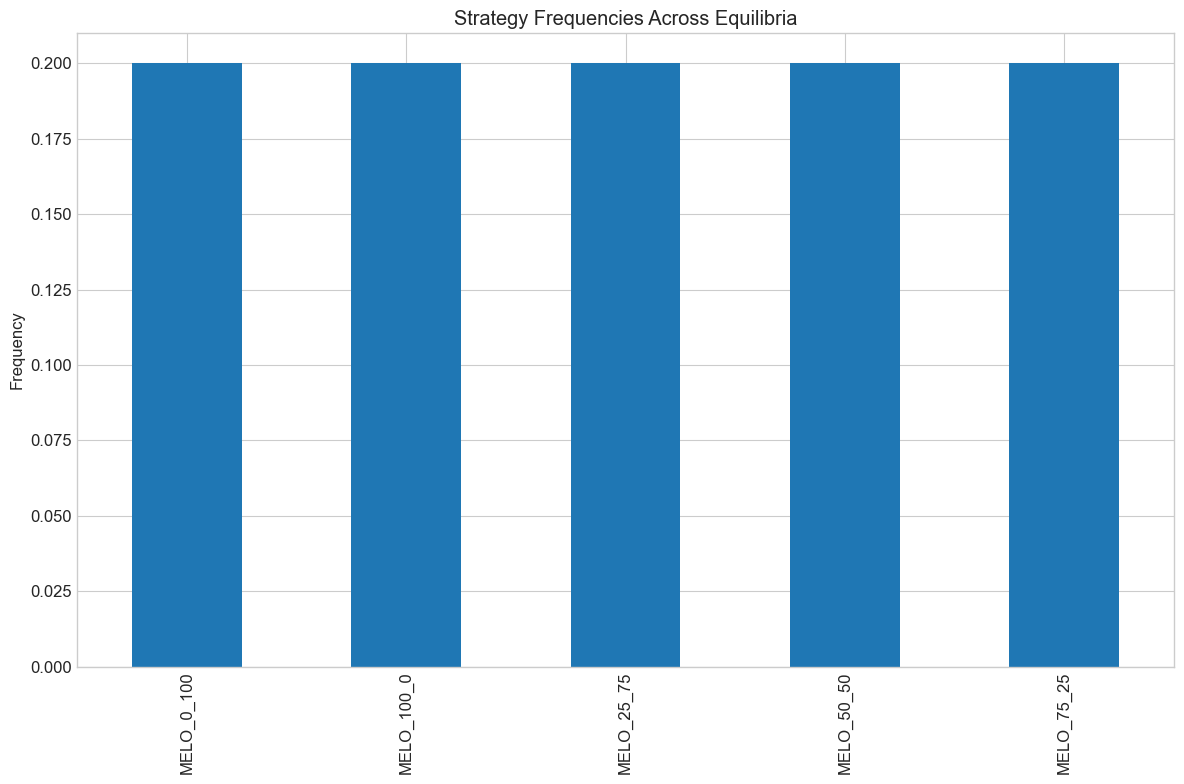

In [19]:
# Print top strategies
print("Top strategies by frequency:")
for strategy, freq in analysis['top_strategies']:
    print(f"  {strategy}: {freq:.4f}")

# Create a bar chart of strategy frequencies
strategy_freqs = pd.Series(analysis['strategy_frequencies'])
strategy_freqs.sort_values(ascending=False).plot(kind='bar')
plt.title('Strategy Frequencies Across Equilibria')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()  

## 4. Visualizing Results

## TODO FIX THIS

In [20]:
# Plot the equilibria as a heatmap
'''
plot_equilibria(
    game=game,
    equilibria=egta.equilibria,
    output_file=os.path.join(output_dir, 'equilibria.png'),
    show=True
)
'''

"\nplot_equilibria(\n    game=game,\n    equilibria=egta.equilibria,\n    output_file=os.path.join(output_dir, 'equilibria.png'),\n    show=True\n)\n"

In [21]:
# Plot strategy frequency
'''
plot_strategy_frequency(
    equilibria=egta.equilibria,
    strategy_names=game.strategy_names,
    output_file=os.path.join(output_dir, 'strategy_frequency.png'),
    show=True
)
'''

"\nplot_strategy_frequency(\n    equilibria=egta.equilibria,\n    strategy_names=game.strategy_names,\n    output_file=os.path.join(output_dir, 'strategy_frequency.png'),\n    show=True\n)\n"

In [22]:
# Plot payoff matrix
''''
plot_payoff_matrix(
    game=game,
    output_file=os.path.join(output_dir, 'payoff_matrix.png'),
    show=True
)
'''

"'\nplot_payoff_matrix(\n    game=game,\n    output_file=os.path.join(output_dir, 'payoff_matrix.png'),\n    show=True\n)\n"

In [23]:
# Plot regret landscapes for pairs of strategies
# This helps visualize where the equilibria are located
''''
if len(game.strategy_names) <= 5:  # Only if we have a manageable number of strategies
    for i in range(len(game.strategy_names)):
        for j in range(i+1, len(game.strategy_names)):
            plot_regret_landscape(
                game=game,
                strategies=[game.strategy_names[i], game.strategy_names[j]],
                resolution=50,  # Reduced resolution for speed
                output_file=os.path.join(output_dir, f'regret_landscape_{i}_{j}.png'),
                show=True
            )
'''

"'\nif len(game.strategy_names) <= 5:  # Only if we have a manageable number of strategies\n    for i in range(len(game.strategy_names)):\n        for j in range(i+1, len(game.strategy_names)):\n            plot_regret_landscape(\n                game=game,\n                strategies=[game.strategy_names[i], game.strategy_names[j]],\n                resolution=50,  # Reduced resolution for speed\n                output_file=os.path.join(output_dir, f'regret_landscape_{i}_{j}.png'),\n                show=True\n            )\n"

In [24]:
# Create a comprehensive visualization report
'''
vis_dir = os.path.join(output_dir, 'visualizations')
report_path = create_visualization_report(
    game=game,
    equilibria=egta.equilibria,
    output_dir=vis_dir
)

print(f"Visualization report saved to {report_path}")
print("Open this HTML file in a browser to view the visualization report")
'''

'\nvis_dir = os.path.join(output_dir, \'visualizations\')\nreport_path = create_visualization_report(\n    game=game,\n    equilibria=egta.equilibria,\n    output_dir=vis_dir\n)\n\nprint(f"Visualization report saved to {report_path}")\nprint("Open this HTML file in a browser to view the visualization report")\n'

## 5. Parameter Sweeps

Now let's explore how different market conditions affect the equilibrium strategies by running parameter sweeps.

In [25]:
def run_experiment(holding_period, lam):
    """Run an EGTA experiment with specific parameters."""
    # Create experiment directory
    exp_dir = f"{output_dir}/sweep_h{holding_period}_lam{lam}"
    os.makedirs(exp_dir, exist_ok=True)
    
    # Create simulator with specific parameters
    simulator = MeloSimulator(
        num_players=10,
        sim_time=1000,
        lam=lam,             # Vary arrival rate
        mean=100,
        r=0.05,
        q_max=10,
        holding_period=holding_period,  # Vary holding period
        reps=2  # Use fewer repetitions for speed
    )
    
    # Create scheduler
    scheduler = DPRScheduler(
        strategies=simulator.get_strategies(),
        num_players=simulator.get_num_players(),
        subgame_size=min(4, len(simulator.get_strategies())),
        batch_size=3,
        seed=42
    )
    
    # Create EGTA framework
    egta = EGTA(
        simulator=simulator,
        scheduler=scheduler,
        device="cpu",
        output_dir=exp_dir,
        max_profiles=30,
        seed=42
    )
    
    # Run with fewer iterations for the parameter sweep
    game = egta.run(
        max_iterations=3,
        profiles_per_iteration=3,
        save_frequency=1,
        verbose=False  # Less verbose for parameter sweep
    )
    
    # Analyze equilibria
    analysis = egta.analyze_equilibria(verbose=False)
    
    # Save analysis
    with open(os.path.join(exp_dir, 'analysis.json'), 'w') as f:
        json.dump(analysis, f, indent=2)
    
    return {
        'holding_period': holding_period,
        'lam': lam,
        'equilibria': [(mix.tolist(), float(reg)) for mix, reg in egta.equilibria],
        'strategy_frequencies': analysis['strategy_frequencies'],
        'top_strategies': analysis['top_strategies']
    }

In [26]:
# Define parameter grid
holding_periods = [1, 5, 10]  # Different MELO holding periods
lambdas = [0.05, 0.1, 0.2]    # Different arrival rates

# Run experiments
results = []
for h in holding_periods:
    print(f"Processing holding period: {h}")
    for lam in lambdas:
        print(f"\nRunning experiment with holding_period={h}, lambda={lam}")
        result = run_experiment(h, lam)
        results.append(result)
        print(f"Completed experiment. Found {len(result['equilibria'])} equilibria.")

# Save all results
with open(os.path.join(output_dir, 'parameter_sweep_results.json'), 'w') as f:
    json.dump(results, f, indent=2)

Processing holding period: 1

Running experiment with holding_period=1, lambda=0.05
Simulating profile 1/3: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_0_100', 'MELO_50_50']
At the end of the simulation we get {-10: tensor(0.), -9: tensor(0.), -8: tensor(0.), -7: tensor(0.), -6: tensor(0.), -5: tensor(0.), -4: tensor(0.), -3: tensor(0.), -2: tensor(0.), -1: tensor(0.), 0: tensor(0.), 1: tensor(0.), 2: tensor(0.), 3: tensor(0.), 4: tensor(0.), 5: tensor(0.), 6: tensor(0.), 7: tensor(0.), 8: tensor(0.), 9: tensor(0.), 10: tensor(0.), 11: tensor(0.), 12: tensor(0.), 13: tensor(0.), 14: tensor(0.), 15: tensor(0.)}
MELO_ At the end of the simulation we get {-10: 0, -9: 0, -8: 0, -7: 0, -6: 0, -5: 0, -4: 0, -3: 0, -2: 0, -1: 0, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0}
At the end of the simulation we get {-10: tensor(0.), -9: tensor(0.), -8: tensor(0.), -7: t

Top strategy by holding period and arrival rate:


lam,0.05,0.10,0.20
holding_period,,,
1,MELO_0_100,MELO_0_100,MELO_0_100
5,MELO_0_100,MELO_0_100,MELO_0_100
10,MELO_0_100,MELO_0_100,MELO_0_100


<Figure size 1200x800 with 0 Axes>

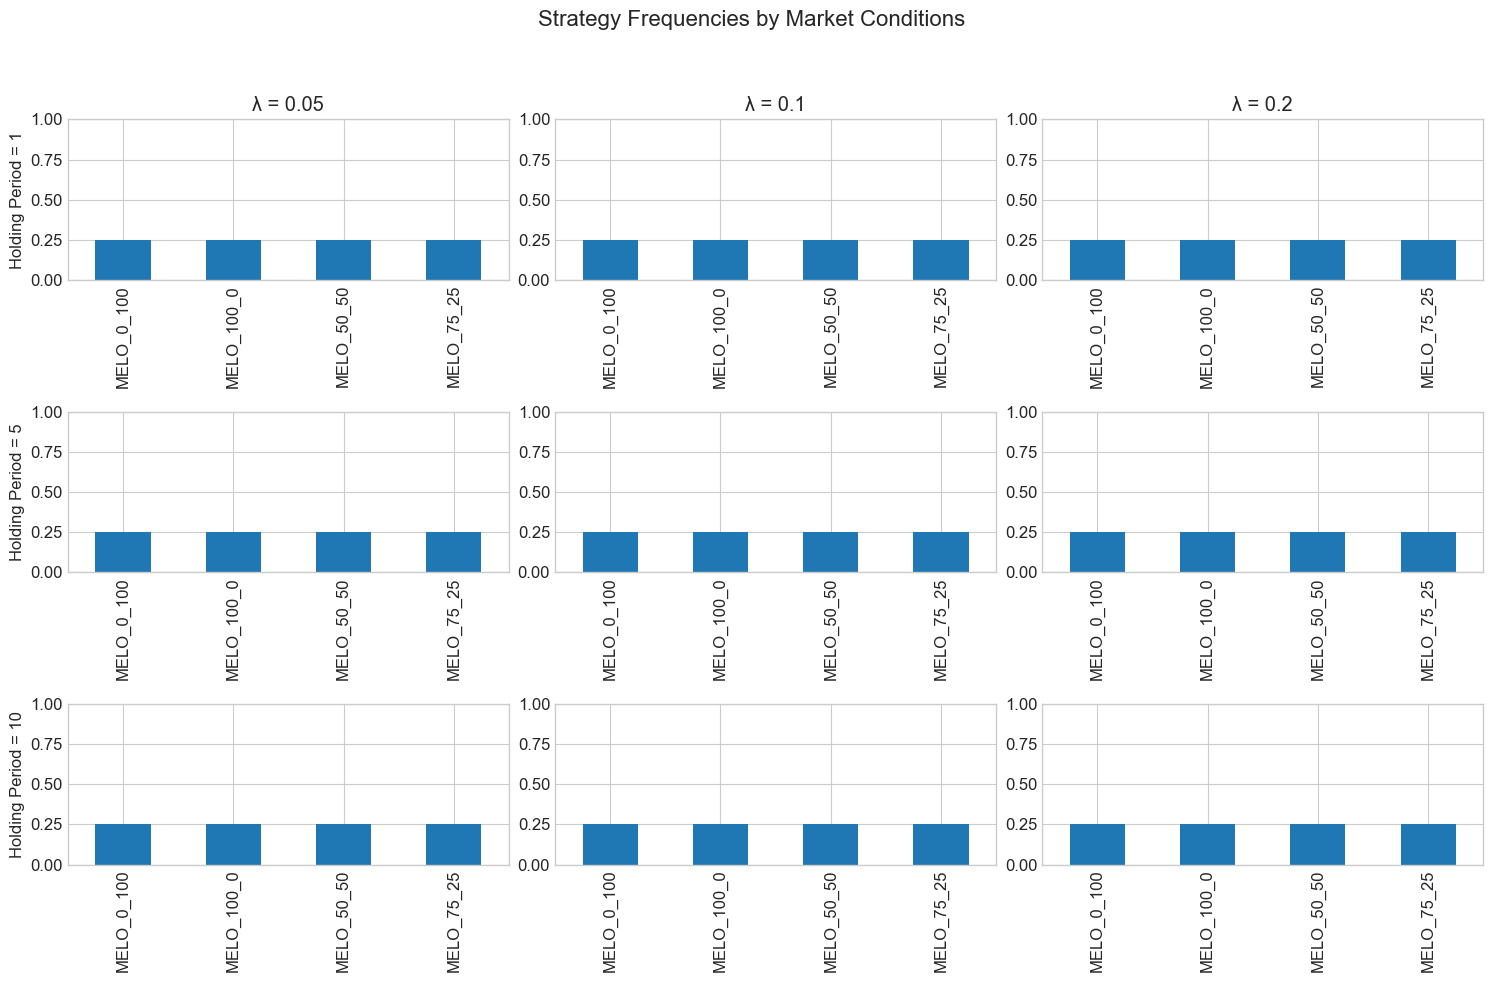

In [27]:
sweep_df = pd.DataFrame(results)

def get_top_strategy(row):
    if row['top_strategies']:
        return row['top_strategies'][0][0] 
    return None

sweep_df['top_strategy'] = sweep_df.apply(get_top_strategy, axis=1)

pivot = pd.pivot_table(
    sweep_df, 
    values='top_strategy', 
    index='holding_period', 
    columns='lam',
    aggfunc=lambda x: x
)

print("Top strategy by holding period and arrival rate:")
display(pivot)

plt.figure(figsize=(12, 8))
strategies = simulator.get_strategies()

fig, axes = plt.subplots(len(holding_periods), len(lambdas), figsize=(15, 10))
fig.suptitle('Strategy Frequencies by Market Conditions', fontsize=16)

for i, h in enumerate(holding_periods):
    axes[i, 0].set_ylabel(f'Holding Period = {h}')
    
for j, lam in enumerate(lambdas):
    axes[0, j].set_title(f'λ = {lam}')

for i, h in enumerate(holding_periods):
    for j, lam in enumerate(lambdas):
        result = next((r for r in results if r['holding_period'] == h and r['lam'] == lam), None)
        if result:
            freqs = pd.Series(result['strategy_frequencies'])
            freqs.plot(kind='bar', ax=axes[i, j])
            axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), rotation=90)
            axes[i, j].set_ylim(0, 1)
            
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(output_dir, 'parameter_sweep_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

## 6. Advanced EGTA - Custom Strategy Space

Let's explore how to define and analyze a custom strategy space, with more fine-grained allocation proportions.

In [28]:
class CustomMeloSimulator(MeloSimulator):
    """Extended MeloSimulator with custom strategy space."""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # more fine-grained strategy space
        self.strategies = [
            "MELO_100_0",   # 100% CDA, 0% MELO
            "MELO_90_10",   # 90% CDA, 10% MELO
            "MELO_80_20",   # 80% CDA, 20% MELO
            "MELO_70_30",   # 70% CDA, 30% MELO
            "MELO_60_40",   # 60% CDA, 40% MELO
            "MELO_50_50",   # 50% CDA, 50% MELO
            "MELO_40_60",   # 40% CDA, 60% MELO
            "MELO_30_70",   # 30% CDA, 70% MELO
            "MELO_20_80",   # 20% CDA, 80% MELO
            "MELO_10_90",   # 10% CDA, 90% MELO
            "MELO_0_100",   # 0% CDA, 100% MELO
        ]
        
        # strategy parameters
        self.strategy_params = {}
        for strategy in self.strategies:
            # Parse the strategy name to get proportions
            parts = strategy.split('_')
            cda_prop = int(parts[1]) / 100
            melo_prop = int(parts[2]) / 100
            self.strategy_params[strategy] = {
                "cda_proportion": cda_prop,
                "melo_proportion": melo_prop
            }

In [29]:
custom_output_dir = f"{output_dir}/custom_strategy_space"
os.makedirs(custom_output_dir, exist_ok=True)

custom_simulator = CustomMeloSimulator(
    num_players=10,
    sim_time=1000,
    lam=0.1,
    holding_period=5,
    reps=2  # Use fewer repetitions for speed
)

#Print available strategies
strategies = custom_simulator.get_strategies()
print(f"Available strategies: {strategies}")

#Print strategy parameters
print("\nStrategy parameters:")
for strategy in strategies:
    params = custom_simulator.strategy_params[strategy]
    print(f"  {strategy}: CDA={params['cda_proportion']:.2f}, MELO={params['melo_proportion']:.2f}")

Available strategies: ['MELO_100_0', 'MELO_90_10', 'MELO_80_20', 'MELO_70_30', 'MELO_60_40', 'MELO_50_50', 'MELO_40_60', 'MELO_30_70', 'MELO_20_80', 'MELO_10_90', 'MELO_0_100']

Strategy parameters:
  MELO_100_0: CDA=1.00, MELO=0.00
  MELO_90_10: CDA=0.90, MELO=0.10
  MELO_80_20: CDA=0.80, MELO=0.20
  MELO_70_30: CDA=0.70, MELO=0.30
  MELO_60_40: CDA=0.60, MELO=0.40
  MELO_50_50: CDA=0.50, MELO=0.50
  MELO_40_60: CDA=0.40, MELO=0.60
  MELO_30_70: CDA=0.30, MELO=0.70
  MELO_20_80: CDA=0.20, MELO=0.80
  MELO_10_90: CDA=0.10, MELO=0.90
  MELO_0_100: CDA=0.00, MELO=1.00


In [30]:
custom_scheduler = RandomScheduler(
    strategies=strategies,
    num_players=custom_simulator.get_num_players(),
    batch_size=5,
    seed=42
)

custom_egta = EGTA(
    simulator=custom_simulator,
    scheduler=custom_scheduler,
    device="cpu",
    output_dir=custom_output_dir,
    max_profiles=40,
    seed=42
)

In [31]:
print("Starting EGTA experiment with custom strategy space...")
print(f"Analyzing {len(strategies)} different allocation strategies")

custom_game = custom_egta.run(
    max_iterations=4,
    profiles_per_iteration=5,
    save_frequency=1,
    verbose=True
)

print("\nEGTA experiment completed!")

Starting EGTA experiment with custom strategy space...
Analyzing 11 different allocation strategies
Starting EGTA process
Simulator: CustomMeloSimulator
Scheduler: RandomScheduler
Strategies: ['MELO_100_0', 'MELO_90_10', 'MELO_80_20', 'MELO_70_30', 'MELO_60_40', 'MELO_50_50', 'MELO_40_60', 'MELO_30_70', 'MELO_20_80', 'MELO_10_90', 'MELO_0_100']
Number of players: 10
Device: cpu
Maximum profiles: 40
Maximum iterations: 4
Profiles per iteration: 5

Iteration 1/4
Simulating 5 profiles...
Simulating profile 1/5: ['MELO_0_100', 'MELO_90_10', 'MELO_100_0', 'MELO_60_40', 'MELO_70_30', 'MELO_70_30', 'MELO_80_20', 'MELO_90_10', 'MELO_0_100', 'MELO_20_80']
At the end of the simulation we get {-10: tensor(0.), -9: tensor(0.), -8: tensor(0.), -7: tensor(0.), -6: tensor(0.), -5: tensor(0.), -4: tensor(0.), -3: tensor(0.), -2: tensor(0.), -1: tensor(0.), 0: tensor(0.), 1: tensor(0.), 2: tensor(0.), 3: tensor(0.), 4: tensor(0.), 5: tensor(0.), 6: tensor(0.), 7: tensor(0.), 8: tensor(0.), 9: tensor(0.

In [32]:
custom_analysis = custom_egta.analyze_equilibria(verbose=True)

with open(os.path.join(custom_output_dir, 'analysis.json'), 'w') as f:
    json.dump(custom_analysis, f, indent=2)


Equilibria Analysis
Number of equilibria: 1
Average regret: 0.000000
Average support size: 11.00
Support size range: 11 - 11

Top strategies:
  MELO_0_100: 0.0909
  MELO_100_0: 0.0909
  MELO_10_90: 0.0909


In [33]:
custom_vis_dir = os.path.join(custom_output_dir, 'visualizations')
custom_report_path = create_visualization_report(
    game=custom_game,
    equilibria=custom_egta.equilibria,
    output_dir=custom_vis_dir
)

print(f"Visualization report saved to {custom_report_path}")

Visualization report created in results/egta_notebook/custom_strategy_space/visualizations
Visualization report saved to results/egta_notebook/custom_strategy_space/visualizations/report.html


## 7. Analysis of Optimal Allocation Curve

## TODO, WE MIGHT want some analysis of metrics, stats. 


In [34]:
def run_holding_period_sweep(holding_periods):
    """Run experiments across different holding periods."""
    sweep_results = []
    
    for holding_period in tqdm(holding_periods):
        # Create experiment directory
        exp_dir = f"{output_dir}/holding_sweep_{holding_period}"
        os.makedirs(exp_dir, exist_ok=True)
        
        # Create simulator with specific holding period
        sim = CustomMeloSimulator(
            num_players=10,
            sim_time=1000,
            lam=0.1,
            holding_period=holding_period,
            reps=2
        )
        
        # Create scheduler
        sched = DPRScheduler(
            strategies=sim.get_strategies(),
            num_players=sim.get_num_players(),
            subgame_size=5,  # Use a larger subgame size for more exploration
            batch_size=4,
            seed=42
        )
        
        # Create EGTA framework
        egta_instance = EGTA(
            simulator=sim,
            scheduler=sched,
            device="cpu",
            output_dir=exp_dir,
            max_profiles=30,
            seed=42
        )
        
        # Run EGTA
        game = egta_instance.run(
            max_iterations=3,
            profiles_per_iteration=4,
            save_frequency=1,
            verbose=False
        )
        
        # Analyze equilibria
        analysis = egta_instance.analyze_equilibria(verbose=False)
        
        # Extract CDA proportions from top strategies
        cda_proportions = []
        for eq_mix, _ in egta_instance.equilibria:
            eq_strat_freqs = dict(zip(game.strategy_names, eq_mix.tolist()))
            weighted_cda_prop = 0
            for strat, freq in eq_strat_freqs.items():
                if freq > 0.01:  # Only count strategies with significant probability
                    cda_prop = sim.strategy_params[strat]['cda_proportion']
                    weighted_cda_prop += cda_prop * freq
            cda_proportions.append(weighted_cda_prop)
        
        # Calculate average CDA proportion
        avg_cda_prop = np.mean(cda_proportions) if cda_proportions else None
        
        # Save results
        result = {
            'holding_period': holding_period,
            'avg_cda_proportion': avg_cda_prop,
            'cda_proportions': cda_proportions,
            'num_equilibria': len(egta_instance.equilibria),
            'top_strategies': analysis['top_strategies']
        }
        sweep_results.append(result)
        
    return sweep_results

In [35]:
# Run a sweep across different holding periods
holding_periods = [1, 2, 3, 5, 7, 10, 15, 20]
holding_sweep_results = run_holding_period_sweep(holding_periods)

# Save results
with open(os.path.join(output_dir, 'holding_period_sweep_results.json'), 'w') as f:
    json.dump(holding_sweep_results, f, indent=2)

  0%|          | 0/8 [00:00<?, ?it/s]

Simulating profile 1/4: ['MELO_60_40', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']
At the end of the simulation we get {-10: tensor(0.), -9: tensor(0.), -8: tensor(0.), -7: tensor(0.), -6: tensor(0.), -5: tensor(0.), -4: tensor(0.), -3: tensor(0.), -2: tensor(0.), -1: tensor(0.), 0: tensor(0.), 1: tensor(0.), 2: tensor(0.), 3: tensor(0.), 4: tensor(0.), 5: tensor(0.), 6: tensor(0.), 7: tensor(0.), 8: tensor(0.), 9: tensor(0.), 10: tensor(0.), 11: tensor(0.), 12: tensor(0.), 13: tensor(0.), 14: tensor(0.), 15: tensor(0.)}
MELO_ At the end of the simulation we get {-10: 0, -9: 0, -8: 0, -7: 0, -6: 0, -5: 0, -4: 0, -3: 0, -2: 0, -1: 0, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0}
At the end of the simulation we get {-10: tensor(0.), -9: tensor(0.), -8: tensor(0.), -7: tensor(0.), -6: tensor(0.), -5: tensor(0.), -4: tensor(0.), -3: tensor(0.), -2: tenso

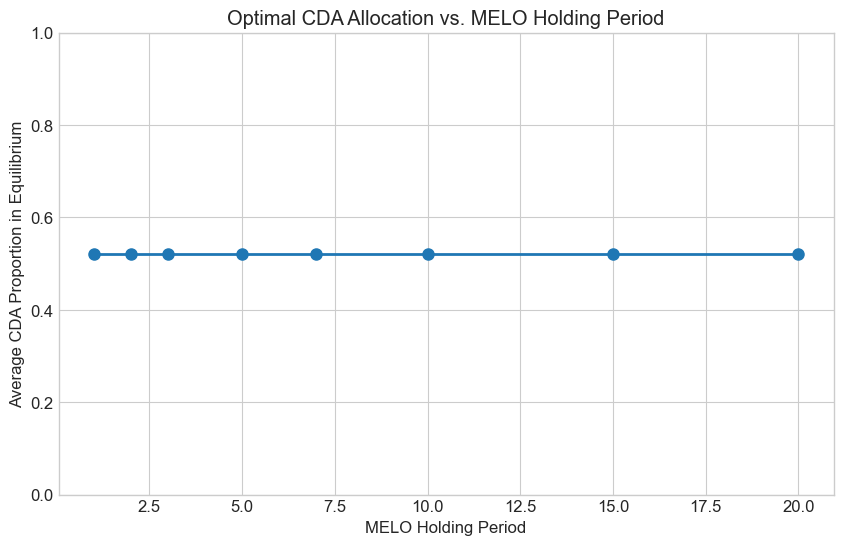

,holding_period,avg_cda_proportion,num_equilibria
0,1,0.52,1
1,2,0.52,1
2,3,0.52,1
3,5,0.52,1
4,7,0.52,1
5,10,0.52,1
6,15,0.52,1
7,20,0.52,1


In [36]:
# Create a dataframe from results
holding_df = pd.DataFrame(holding_sweep_results)

# Plot the relationship between holding period and CDA proportion
plt.figure(figsize=(10, 6))
plt.plot(holding_df['holding_period'], holding_df['avg_cda_proportion'], 'o-', linewidth=2, markersize=8)
plt.xlabel('MELO Holding Period')
plt.ylabel('Average CDA Proportion in Equilibrium')
plt.title('Optimal CDA Allocation vs. MELO Holding Period')
plt.grid(True)
plt.ylim(0, 1)
plt.savefig(os.path.join(output_dir, 'optimal_allocation_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

# Display the data
display(holding_df[['holding_period', 'avg_cda_proportion', 'num_equilibria']])